In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import itertools
import math
import os
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/mraz9/nltk_data...


True

# Step 1 : 영화 데이터 파일 불러오기

In [23]:
movies = pd.read_csv(r"movies.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv
user_ratings = pd.read_csv(r"ratings.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv 편집
user_ratings = user_ratings.sort_values('userId').reset_index(drop = True)
user_ratings_test =  pd.read_csv(r"ratings.csv")

In [6]:
print(user_ratings.head(5))
print(user_ratings.tail(5))

   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1     3997     3.5  1112486192
2       1     4011     4.0  1112485406
3       1     4027     4.0  1112485460
4       1     4105     3.5  1094786104
          userId  movieId  rating   timestamp
20000258  138493     2006     4.0  1256750301
20000259  138493     2002     4.5  1255817431
20000260  138493     2001     4.5  1255817429
20000261  138493     2081     4.0  1256750604
20000262  138493    71619     2.5  1255811136


In [7]:
user_ratings_test = user_ratings_test.drop(['userId','movieId','timestamp'],axis=1)


In [8]:
# rating의 평균 값은 3.52이고 상위 25%가 4.0 이상이므로 4.5정도면 고평점이라고 판단했다. 유저가 고평점을 메겼다는 것은 유저의 취향을 
# 반영하는 것이라고 판단하고 앞으로 컨텐츠 추천과정에서 4.5 이상의 평점 데이터셋을 필터링하여 추천을 진행하고자 한다. 

user_ratings_test.describe()

,rating
count,2.000026e+07
mean,3.525529e+00
std,1.051989e+00
min,5.000000e-01
25%,3.000000e+00
50%,3.500000e+00
75%,4.000000e+00
max,5.000000e+00


In [18]:
# 유저별 평균 평점은 다음과 같다. 유저마다 부여한 평균 점수는 다양하다. 
data2 = user_ratings[['userId',   'rating']]
movie_list2 = (((data2.sort_values(by = 'userId')).groupby('userId')))['rating']
movie_list2 = movie_list2.mean()
movie_list2

userId
1         3.742857
2         4.000000
3         4.122995
4         3.571429
5         4.272727
            ...   
138489    3.986842
138490    3.556291
138491    2.681818
138492    4.097561
138493    4.172922
Name: rating, Length: 138493, dtype: float64

In [12]:
# 유저마다 rating을 다양하게 부여했지만 평균 평점이 4.5 이상의 평점은 아무도 없기에 4.5점이면 고평점이라고 판단했다.
# movie_list2 = pd.DataFrame(movie_list2, columns = ['rating']).sort_values('userId').reset_index(drop = True)
# Higher4_5 = movie_list2[[movie_list2.rating>=4.5]]

In [24]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


### 영화 데이터 전처리

In [22]:
# 장르 벡터화 
def genre_array(str):
    return str.split('|')

movies['genres'] = movies['genres'].apply(genre_array)
print(movies['genres'])
movies2 = movies[:]
print(movies2)

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
27273                                             [Comedy]
27274                                             [Comedy]
27275                                          [Adventure]
27276                                 [(no genres listed)]
27277                         [Adventure, Fantasy, Horror]
Name: genres, Length: 27278, dtype: object
       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Pa

In [25]:
# 장르 벡터화 
def genre_array(str):
    return str.split('|')

movies['genres'] = movies['genres'].apply(genre_array)
movies2 = movies[:]



from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
movies = movies.join(pd.DataFrame(mlb.fit_transform(movies.pop('genres')),
                          columns=mlb.classes_,
                          index=movies.index))
movies

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27275,131258,The Pirates (2014),0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27276,131260,Rentun Ruusu (2001),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### user_ratings data 와 movies data 합치기 

In [26]:
movielens = pd.merge(user_ratings, movies, on = 'movieId')
# movielens.shape()

In [27]:
movielens

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,1112486027,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5,2,3.0,851527569,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,13,2,3.0,849082742,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,29,2,3.0,835562174,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,34,2,3.0,846509384,Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000258,138301,121019,4.5,1420558606,The Great Spy Chase (1964),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20000259,138301,106170,4.0,1383873162,"Patriots, The (Patriotes, Les) (1994)",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20000260,138301,106401,3.0,1394152234,Le convoyeur (2004),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20000261,138406,110167,4.5,1396184127,"Judge and the Assassin, The (Juge et l'assassi...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 영화별 평균 평점 데이터 

In [29]:
data = movielens[['userId', 'movieId', 'title', 'rating']]
movie_list = (((data.sort_values(by = 'movieId')).groupby('title')))['movieId', 'title', 'rating']
movie_list = movie_list.mean()
movie_list['title'] = movie_list.index
movie_list = movie_list.to_numpy()
movie_list = pd.DataFrame(movie_list, columns = ['movieId', 'avgRating', 'title']).sort_values('movieId').reset_index(drop = True)
print(movie_list.shape)

/var/folders/x4/z7w83zkj1q92z10zj7s__cxc0000gn/T/ipykernel_14737/2678183036.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movie_list = (((data.sort_values(by = 'movieId')).groupby('title')))['movieId', 'title', 'rating']


(26729, 3)


/var/folders/x4/z7w83zkj1q92z10zj7s__cxc0000gn/T/ipykernel_14737/2678183036.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  movie_list = movie_list.mean()


# Step 2 : K - Means & KNN

In [30]:
# 고평점의 데이터 추출 (앞서 왜 4.5이상을 추출했는지 설명하였다.)
good_data = movielens[movielens.rating >= 4.5]

# 유저별 평가한 영화에 대해 앞서 만들어 놓은 장르 벡터를 합쳤다. 예를 들어 userID 1은 Action movie 4개에 대하여 4.5이상의 평점을 주었다.
data = good_data[:]
data = data.groupby('userId').aggregate(np.sum)
del data['movieId']
del data['rating']
del data['timestamp']
data.head()

/var/folders/x4/z7w83zkj1q92z10zj7s__cxc0000gn/T/ipykernel_14737/2881183972.py:6: FutureWarning: The operation <function sum at 0x103f00820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  data = data.groupby('userId').aggregate(np.sum)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0,4,6,0,0,0,1,0,2,3,0,1,1,0,0,0,2,0,0,0
2,0,12,14,0,0,4,1,0,6,0,1,6,0,0,2,2,15,11,1,1
3,0,25,22,0,4,20,12,0,27,8,0,8,0,2,6,5,31,23,4,2
4,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0
5,0,11,15,5,7,13,4,0,13,4,0,0,3,6,0,8,7,8,0,2


In [31]:
data

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0,4,6,0,0,0,1,0,2,3,0,1,1,0,0,0,2,0,0,0
2,0,12,14,0,0,4,1,0,6,0,1,6,0,0,2,2,15,11,1,1
3,0,25,22,0,4,20,12,0,27,8,0,8,0,2,6,5,31,23,4,2
4,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0
5,0,11,15,5,7,13,4,0,13,4,0,0,3,6,0,8,7,8,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138489,0,2,1,2,2,2,7,0,9,0,1,0,0,0,3,1,0,3,0,0
138490,0,0,0,0,2,0,2,0,14,1,0,1,0,0,2,2,2,5,1,0
138491,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0


In [32]:
# userID가 target이다. 
target = pd.DataFrame(sorted(good_data['userId'].unique()))
# 이 data 변수는 유저가 고평점을 메긴 영화 장르 벡터이며 k_means와 knn에 들어갈 input data 이다. 
data = data.set_index([[i for i in range(136472)]])

In [33]:
print(target)
print(data)

             0
0            1
1            2
2            3
3            4
4            5
...        ...
136467  138489
136468  138490
136469  138491
136470  138492
136471  138493

[136472 rows x 1 columns]
        (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
0                        0       4          6          0         0       0   
1                        0      12         14          0         0       4   
2                        0      25         22          0         4      20   
3                        0       1          1          0         0       0   
4                        0      11         15          5         7      13   
...                    ...     ...        ...        ...       ...     ...   
136467                   0       2          1          2         2       2   
136468                   0       0          0          0         2       0   
136469                   0       0          1          1         0       1   
136470       

In [19]:
data.shape

(136472, 20)

In [20]:
target.shape

(136472, 1)

In [21]:
data

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,4,6,0,0,0,1,0,2,3,0,1,1,0,0,0,2,0,0,0
1,0,12,14,0,0,4,1,0,6,0,1,6,0,0,2,2,15,11,1,1
2,0,25,22,0,4,20,12,0,27,8,0,8,0,2,6,5,31,23,4,2
3,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0
4,0,11,15,5,7,13,4,0,13,4,0,0,3,6,0,8,7,8,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136467,0,2,1,2,2,2,7,0,9,0,1,0,0,0,3,1,0,3,0,0
136468,0,0,0,0,2,0,2,0,14,1,0,1,0,0,2,2,2,5,1,0
136469,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
136470,0,10,7,1,0,28,6,5,15,4,1,0,0,3,1,12,2,4,1,2


In [22]:
target

,0
0,1
1,2
2,3
3,4
4,5
...,...
136467,138489
136468,138490
136469,138491
136470,138492


In [23]:
# 모든 데이터 사용시 코드가 돌아가는 시간만 5시간 넘게 걸림. 따라서 3000개 데이터 추출 
temp_target = target[:3000]
temp_data = data[:3000]

In [24]:
data2 = temp_data.copy()

In [25]:
b = temp_target.to_numpy().ravel()
b

array([   1,    2,    3, ..., 3045, 3046, 3047], dtype=int64)

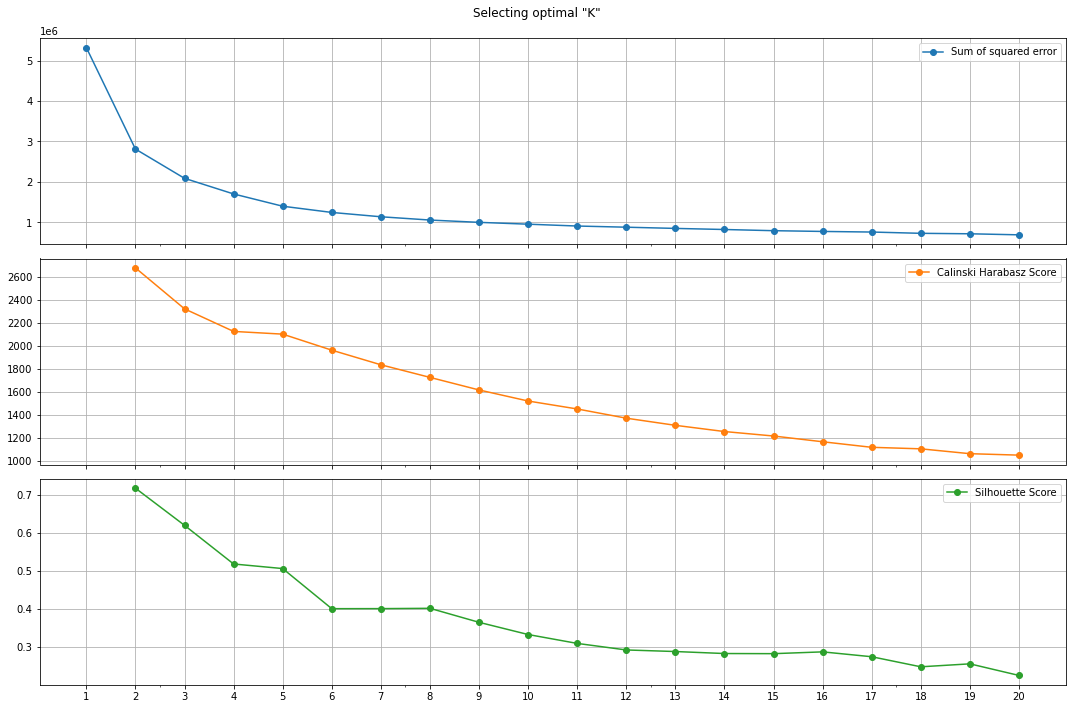

In [26]:
# K-means clustering 진행
# SSE에서 elbow point도 k=2에 있고 Calinski Harabasz Score와 Silhouette Score의 최대값도 k=2 일때여서 적절한 k 값은 2라고 할 수 
# 있지만 3000개의 데이터 에서 k=2값은 너무 작고 k 값이 너무 작으면 overfitting 문제가 발생할 수 았기에 SSE, Calinski Harabasz Score,
# Silhouette Score 계수가 적당히 큰 k=4지점을 적절한 k 값으로 선정하였다. 참고로 k=3으로 진행했을 때 k=4로 진행했을때와 결과가
# 별반 다르지 않아 overfitting을 조금이라도 방지하고자 k=4 를 적절한 k 값으로 채택하였다. 
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(data2)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(data2)
        chs = calinski_harabasz_score(data2, cluster)
        ss = silhouette_score(data2, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

In [27]:
# 앞선 주석에서 설명처럼 적절한 k 값은 4라 판단하였다.
from sklearn.cluster import KMeans
'''
init: {'k-means++', 'random'}, default='k-means++'
algorithm: {'auto', 'full', 'elkan'}, default='auto'
'''

model = KMeans(n_clusters=4, random_state=312, algorithm='auto')
model.fit(data2)

KMeans(n_clusters=4, random_state=312)

In [28]:
a = model.labels_

In [29]:
a

array([3, 3, 0, ..., 3, 3, 0])

In [30]:
temp_target = pd.DataFrame({'class':a,
                            'ID' : b
})
temp_target

,class,ID
0,3,1
1,3,2
2,0,3
3,3,4
4,3,5
...,...,...
2995,3,3043
2996,3,3044
2997,3,3045
2998,3,3046


In [88]:
temp_target.transpose()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
class,3,3,0,3,3,3,3,3,3,3,...,3,0,0,3,0,3,3,3,3,0
ID,1,2,3,4,5,6,7,8,9,10,...,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047


In [31]:
# Train Test 에 대하여 8:2 분할 후 Train Valid를 다시 8:2 분할하였다.
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train2, Y_Test2 = train_test_split(
    temp_data, temp_target, test_size=0.2, random_state=42)
X_Train, X_Valid, Y_Train2, Y_Valid2 = train_test_split(X_Train,Y_Train2,test_size = 0.2, random_state = 50)
# 8:2 분할
train_start = 1
train_end = 1920
test_start = 1921
test_end = 2520
Y_Train2


,class,ID
1358,3,1375
2944,3,2991
49,3,51
1132,0,1147
738,3,750
...,...,...
50,3,52
488,3,498
2305,3,2339
1855,0,1883


In [32]:
X_Train = X_Train.to_numpy()
X_Valid = X_Valid.to_numpy()
X_Test = X_Test.to_numpy()

Y_Train = Y_Train2['class'].to_numpy().ravel()
Y_Valid = Y_Valid2['class'].to_numpy().ravel()
Y_Test = Y_Test2['class'].to_numpy().ravel()

Y_Test

array([3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 1, 3, 1, 0, 3, 3, 3, 0, 0, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 2, 0, 0, 3, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       3, 3, 0, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 2, 3, 2, 3, 3, 0, 0, 3, 0,
       3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 0,
       0, 2, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 2,
       3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 2,
       3, 3, 0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0,
       0, 3, 3, 0, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3,

In [33]:
Y_Train

array([3, 3, 3, ..., 3, 0, 0])

In [34]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
앞서 k-means를 통해 유저별 군집화를 이루었고 이 군집결과를 정답 데이터로 하는 KNN 진행한다. 이때 input 값은 앞서 설명했듯 유저가 고평점을
메긴 장르 벡터의 합이다. 
1~50 까지 k 값을 조정해보면서 classifier score를 계산했고 best k 값은 8이 나왔다.  
'''
k_list = range(1,51) # k= 1~50까지 조절 
accuracies = []
best_k = 0
best_acc = 0
k_index = []

for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_Train,Y_Train)
    # Validation dataset으로 k score 계산 
    acc = classifier.score(X_Valid, Y_Valid)
    accuracies.append(acc)
    k_index.append(k)
    if best_acc < acc:
        best_acc = acc
        best_k = k

print(best_k)
k_list2 = pd.DataFrame(data ={'accuracy':accuracies},
                      index= k_index)
k_list2



8


,accuracy
1,0.966667
2,0.970833
3,0.968750
4,0.970833
5,0.966667
6,0.975000
7,0.968750
8,0.979167
9,0.972917
10,0.970833


In [35]:
Y_Test

array([3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 1, 3, 1, 0, 3, 3, 3, 0, 0, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 2, 0, 0, 3, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       3, 3, 0, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 2, 3, 2, 3, 3, 0, 0, 3, 0,
       3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 0,
       0, 2, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 2,
       3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 2,
       3, 3, 0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0,
       0, 3, 3, 0, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3,

In [36]:
# knn classifier 모델을 best k값인 k=8로 학습을 시키고 test data에 대하여 neighbor를 알아보고자 한다.
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = best_k)
KNN.fit(X_Train, Y_Train)
distances, neighbors = KNN.kneighbors(X_Test)

In [38]:
d = Y_Train2['ID'].to_numpy()
d

array([1375, 2991,   51, ..., 2339, 1883, 2174], dtype=int64)

In [39]:
Y_Test[4]    #class--> User ID 2542는 3번째 군집에 속한다.

3

In [40]:
c = Y_Test2['ID'].to_numpy()
c[4]         #ID --> 4번째 index는 유저 ID 2542이다. 

2542

In [41]:
neighbors

array([[1912, 1406,  577, ...,  224, 1520,  512],
       [ 567, 1857,  820, ...,  895, 1488,  762],
       [ 330,  540,   16, ...,  599, 1672,   59],
       ...,
       [1582,  722,  269, ...,  434,  226,  262],
       [ 243,  870,  453, ...,  353, 1897,  610],
       [1229,   80,  803, ...,  291,  972, 1572]], dtype=int64)

### 예시 : 유저 2542

In [42]:
# 유저 2542의 neighbor index
print (neighbors[4])

[1039  665  745  539  746 1667 1892  741]


In [43]:
# neighbor는 index 값이기에 유저 id를 추출해주는 코드작성
new_list = []
for i in range(test_end - train_end):
    x = neighbors[i]
    x = np.array(x, dtype = int)
    new_list.append(d[x].ravel())
neighbors = np.array(new_list)
neighbors

array([[2773,  917, 1054, ..., 2221, 2679, 1818],
       [ 580, 1345, 2040, ..., 1310, 3008,  706],
       [2759, 1868,  588, ..., 2982, 2848,  465],
       ...,
       [2082, 2004, 2068, ..., 1705, 1515, 1746],
       [ 807, 2582,  993, ...,  562, 2609, 1739],
       [1526, 1096, 2414, ..., 1482,  637,   81]], dtype=int64)

In [44]:
print ("2542와 동일한 범주에 있는 사용자(neighbor)",neighbors[4] )


2542와 동일한 범주에 있는 사용자 [ 995 2402  570  789  194 2694  369 1842]


In [45]:
Y_Train2

,class,ID
1358,3,1375
2944,3,2991
49,3,51
1132,0,1147
738,3,750
...,...,...
50,3,52
488,3,498
2305,3,2339
1855,0,1883


# Step 3 : 같은 군집내 neighbor를 기반으로 새로운 movie 추천

In [46]:
import time
import datetime
start_time = time.time()

nearest = best_k

# 유저에게 4개의 영화 추천

final_recommendations_knn = []
for i in range(0, test_end - train_end):
    temp_list = []
    for j in range(nearest):
        # neighbor class 찾기
        nclass = Y_Train2[Y_Train2['ID'] == neighbors[i][j]]
        nclass = nclass.iloc[0]['class']
        
        # test user의 neighbor 중 test user와 같은 class인 유저만 추출
        if nclass == Y_Test[i]: 
            temp_list.append(neighbors[i][j])
    full_list = good_data[good_data.userId == temp_list[0]].movieId.to_numpy()
    for k in range(1, len(temp_list)):
        full_list = list(set().union(full_list, good_data[good_data.userId == temp_list[k]].movieId.to_numpy()))
    full_list = np.array(full_list)
    
    common_list = np.intersect1d(full_list, good_data[good_data.userId == c[i]].movieId.to_numpy())

    
    recommendation = np.setdiff1d(full_list, common_list)
    recommendation_list = []
    for i in recommendation:
        if(movie_list[movie_list.movieId == i].to_numpy().size != 0):
            recommendation_list.append(list(movie_list[movie_list.movieId == i].to_numpy()[0]))
    recommendation = (pd.DataFrame(recommendation_list,columns = ['movieId','mean rating' ,'title'])).sort_values(by = 'mean rating', ascending = False)
    final_recommendations_knn.append(recommendation)

RunTime = time.time()-start_time
RunTime_measure = str(datetime.timedelta(seconds=RunTime)).split('.')[0]
print(RunTime_measure)

1:11:54


In [47]:
for i in range(0, test_end - train_end):
    print ("\n", c[i],"번 유저에게 다음과 같은 4개의 영화를 추천한다", "\n", final_recommendations_knn[i][:4][['mean rating' ,'title']])


 1827 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
17     4.446990  Shawshank Redemption, The (1994)
35     4.364732             Godfather, The (1972)
5      4.334372        Usual Suspects, The (1995)
27     4.310175           Schindler's List (1993)

 1205 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                                        title
21     4.364732                        Godfather, The (1972)
2      4.334372                   Usual Suspects, The (1995)
34     4.275641               Godfather: Part II, The (1974)
56     4.274180  Seven Samurai (Shichinin no samurai) (1954)

 1844 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
30     4.446990  Shawshank Redemption, The (1994)
10     4.334372        Usual Suspects, The (1995)
51     4.310175           Schindler's List (1993)
80     4.258327                 Casablanca (1942)

 255 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                       title
43     4

55     4.248079  One Flew Over the Cuckoo's Nest (1975)

 250 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                           title
15     4.364732           Godfather, The (1972)
3      4.334372      Usual Suspects, The (1995)
23     4.275641  Godfather: Part II, The (1974)
17     4.271334              Rear Window (1954)

 565 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
8      4.446990  Shawshank Redemption, The (1994)
16     4.364732             Godfather, The (1972)
12     4.310175           Schindler's List (1993)
34     4.275641    Godfather: Part II, The (1974)

 1778 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
22     4.446990  Shawshank Redemption, The (1994)
31     4.364732             Godfather, The (1972)
27     4.310175           Schindler's List (1993)
50     4.227123                 Fight Club (1999)

 1382 번 유저에게 다음과 같은 4개의 영화를 추천한다 
      mean rating                                              

 2156 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                                        title
22     4.446990             Shawshank Redemption, The (1994)
44     4.364732                        Godfather, The (1972)
57     4.274180  Seven Samurai (Shichinin no samurai) (1954)
59     4.155934                       American Beauty (1999)

 2657 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
30     4.446990  Shawshank Redemption, The (1994)
71     4.364732             Godfather, The (1972)
8      4.334372        Usual Suspects, The (1995)
46     4.310175           Schindler's List (1993)

 2324 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
23     4.446990  Shawshank Redemption, The (1994)
51     4.364732             Godfather, The (1972)
41     4.310175           Schindler's List (1993)
65     4.275641    Godfather: Part II, The (1974)

 776 번 유저에게 다음과 같은 4개의 영화를 추천한다 
      mean rating                             title
33

18     4.271334                Rear Window (1954)

 538 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                                      title
46     4.220129                    Dark Knight, The (2008)
17     4.190672  Star Wars: Episode IV - A New Hope (1977)
40     4.187186                         Matrix, The (1999)
19     4.174231                        Pulp Fiction (1994)

 2252 번 유저에게 다음과 같은 4개의 영화를 추천한다 
     mean rating                             title
18     4.446990  Shawshank Redemption, The (1994)
6      4.334372        Usual Suspects, The (1995)
27     4.310175           Schindler's List (1993)
37     4.271334                Rear Window (1954)

 438 번 유저에게 다음과 같은 4개의 영화를 추천한다 
    mean rating                                             title
3     4.446990                  Shawshank Redemption, The (1994)
5     4.109839                             Cool Hand Luke (1967)
1     4.089562  Three Colors: Red (Trois couleurs: Rouge) (1994)
2     3.993185  Three Colors: Blue (Tro

# Step 4: 책 데이터 셋 불러오기

### 책 데이터 전처리

In [66]:
books = pd.read_csv(r"booksummaries.txt", sep='\t', names=['Wikipedia_ID', 'Freebase_ID', 'Title', 'Author', 'Pub_Date', 'Genre', 'Plot'])
books.dropna(subset=['Genre'], inplace = True)
del books['Freebase_ID']
del books['Plot']
import ast
def getGenre(str):
    return list(ast.literal_eval(str).values())

books['Genre'] = books['Genre'].apply(getGenre)
books.reset_index(inplace = True, drop = True)
books

,Wikipedia_ID,Title,Author,Pub_Date,Genre
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N..."
3,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul..."
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]"
...,...,...,...,...,...
12836,36372465,The Third Lynx,Timothy Zahn,2007,[Science Fiction]
12837,36534061,Remote Control,Andy McNab,1997,"[Thriller, Fiction, Suspense]"
12838,37054020,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]"
12839,37122323,Decoded,Jay-Z,2010-11-16,[Autobiography]


In [67]:
# book과 movie data에 대한 genre list 추출
books_tags = books['Genre']
tag_table_books = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(books_tags)))]

movies_tags = movies2['genres']
tag_table_movies = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(movies_tags)))]
tag_table_movies

['Drama',
 'Horror',
 'Sci-Fi',
 'Animation',
 'Comedy',
 'Thriller',
 'Romance',
 'Mystery',
 'Crime',
 'Fantasy',
 'Adventure',
 'Children',
 'Action',
 'War',
 'Musical',
 'Western',
 'IMAX',
 '(no genres listed)',
 'Documentary',
 'Film-Noir']

In [68]:
tag_table = pd.DataFrame(tag_table_movies)
tag_table.columns = ['Tag']

tag_table_books = pd.DataFrame(tag_table_books)
tag_table_books.columns = ['Tag']
tag_table

,Tag
0,Drama
1,Horror
2,Sci-Fi
3,Animation
4,Comedy
5,Thriller
6,Romance
7,Mystery
8,Crime
9,Fantasy


In [69]:
tag_books = tag_table_books.to_numpy().ravel()
tag_movies = tag_table['Tag'].to_numpy()

In [70]:
tag_books

array(['Roman à clef', 'Chick lit', 'Feminist science fiction', 'Horror',
       'Sea story', 'Farce', 'Autobiography', 'Cozy', 'Steampunk',
       'Comedy', 'Utopian fiction', 'Post-holocaust', 'Picture book',
       'Music', 'Light novel', 'Poetry', 'Literary criticism',
       'Social novel', 'Indian chick lit', 'Supernatural', 'Novella',
       'Alternate history', 'Neuroscience', 'Historical fantasy', 'Play',
       'Military science fiction', 'Whodunit', 'Humour', 'Low fantasy',
       'Historical romance', 'Religion', 'Fairy tale', 'Popular science',
       'Travel', 'First-person narrative', 'Western',
       'Ergodic literature', 'Utopian and dystopian fiction',
       'Graphic novel', 'Sports', 'Philosophy', 'Medieval romance',
       'Psychology', 'Gay novel', 'Police procedural',
       'Invasion literature', "Boys' school stories",
       'Fictional crossover', 'Historical fiction', 'Ghost story',
       'Human extinction', 'Modernism', 'Albino bias', 'Field guide',
      

In [71]:
tag_books.shape

(227,)

In [72]:
tag_movies

array(['Drama', 'Horror', 'Sci-Fi', 'Animation', 'Comedy', 'Thriller',
       'Romance', 'Mystery', 'Crime', 'Fantasy', 'Adventure', 'Children',
       'Action', 'War', 'Musical', 'Western', 'IMAX',
       '(no genres listed)', 'Documentary', 'Film-Noir'], dtype=object)

In [73]:
# wordnet에 없는 단어 제거 
tag_movies = np.delete(tag_movies, [2,16,17,19]) 
tag_movies

array(['Drama', 'Horror', 'Animation', 'Comedy', 'Thriller', 'Romance',
       'Mystery', 'Crime', 'Fantasy', 'Adventure', 'Children', 'Action',
       'War', 'Musical', 'Western', 'Documentary'], dtype=object)

# Step 5 : movie genre와 book genre간의 path_similarity 계산

In [74]:
# path_similarity가 가장 큰 값을 비슷한 장르라고 판단함
def find_relation(str):
    str = str.replace('-', ' ')
    if(len(str.split())==1):
        a = wn.synsets(str)
        if len(a) == 0:
            return 'Null'
        else:
            x = []
            for genre in tag_movies:
                m = wn.synsets(genre)
                x.append(a[0].path_similarity(m[0]))
            x = np.array(x, dtype = float)
            max_idx = x.argmax()
            return tag_movies[max_idx]
    else:
        a = wn.synsets(str.split()[0])
        b = wn.synsets(str.split()[1])
        if len(a) == 0 and len(b) == 0:
            return 'Null'
        elif (len(a) != 0 and len(b) == 0) or (len(a) == 0 and len(b) != 0):
            if len(a) != 0 and len(b) == 0:
                a = wn.synsets(str.split()[0])
            else:
                a = wn.synsets(str.split()[1])
            if len(a) == 0:
                return 'Null'
            else:
                x = []
                for genre in tag_movies:
                    m = wn.synsets(genre)
                    x.append(a[0].path_similarity(m[0]))
                x = np.array(x, dtype = float)
                max_idx = x.argmax()
                return tag_movies[max_idx]
        else:
            x = []
            y = []
            for genre in tag_movies:
                m = wn.synsets(genre)
                x.append(a[0].path_similarity(m[0]))
                y.append(b[0].path_similarity(m[0]))
            x = np.array(x, dtype = float)
            y = np.array(y, dtype = float)
            if (x.max() > y.max()):
                max_idx = x.argmax()
            else:
                max_idx = y.argmax()
            return tag_movies[max_idx]
# movie tag : movie genre를 의미
# tag : book genre 를 의미
tag_table_books['movie_tag'] = tag_table_books['Tag'].apply(find_relation)
tag_table_books.transpose()

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
Tag,Roman à clef,Chick lit,Feminist science fiction,Horror,Sea story,Farce,Autobiography,Cozy,Steampunk,Comedy,...,Reference,Romantic comedy,Transgender and transsexual fiction,Polemic,Conspiracy fiction,Social sciences,American Gothic Fiction,Paranormal romance,Young adult literature,Biopunk
movie_tag,Children,Children,Children,Horror,Drama,Comedy,Drama,Musical,Null,Comedy,...,Drama,Comedy,Animation,Children,Thriller,Fantasy,Children,Romance,Children,Null


# Step 6 : 유저 2542에게 책 추천

In [75]:
# 앞서 유저 2542에게 추천한 movie list를 불러옴
movie_id = final_recommendations_knn[4][:4][['movieId']].to_numpy().ravel()
movie_id = movie_id.astype(int)

In [76]:
movies = pd.read_csv(r"movies.csv")
def genre_array(str):
    return str.split('|')

movies['genre'] = movies['genres'].apply(genre_array)
del movies['genres']

In [77]:
# 앞서 user 2542에게 추천된 movie list 
filtered_dataset = pd.DataFrame([ movies[movies.movieId == i].to_numpy()[0] for i in movie_id], columns = ['movieId', 'title', 'genre'])
filtered_dataset

,movieId,title,genre
0,858,"Godfather, The (1972)","[Crime, Drama]"
1,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"
2,527,Schindler's List (1993),"[Drama, War]"
3,904,Rear Window (1954),"[Mystery, Thriller]"


In [78]:
selected_movie_tags = filtered_dataset['genre']
tag_selected_movies = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(selected_movie_tags)))]
tag_selected_movies

['Thriller', 'Drama', 'Mystery', 'War', 'Crime']

In [79]:
# 유저 2542에게 추천된 movie와 비슷한 책장르(앞서 만든 tag_table_books 표)를 tag_selected_books라는 list로 만듦
tag_selected_books = [ tag_table_books[tag_table_books.movie_tag == i].Tag.to_numpy() for i in tag_selected_movies ]
tag_selected_books = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(tag_selected_books)))]
tag_selected_books

['School story',
 'True crime',
 'Techno-thriller',
 'Spy fiction',
 'Science Fiction',
 'Travel literature',
 'Pastiche',
 'Short story',
 'Drama',
 'Biography',
 'Epic Science Fiction and Fantasy',
 'Sea story',
 'Autobiography',
 'Morality play',
 'Comics',
 'Non-fiction',
 'Superhero fiction',
 'Satire',
 'Subterranean fiction',
 'Utopian fiction',
 'Light novel',
 'Epistolary novel',
 'Picaresque novel',
 'Music',
 'Social criticism',
 'Thriller',
 'LGBT literature',
 'Anti-war',
 'Literary criticism',
 'Conspiracy',
 'Mystery',
 'Treatise',
 'Novel',
 'Social novel',
 'Memoir',
 'Autobiographical novel',
 'Comic novel',
 'Speculative fiction',
 'Novella',
 'Vampire fiction',
 'Historical novel',
 'Personal journal',
 'Parallel novel',
 'Essay',
 'Experimental literature',
 'Play',
 'Whodunit',
 'Social commentary',
 'Religious text',
 'Psychological novel',
 'Detective fiction',
 'Fiction',
 'Urban fiction',
 'Fairy tale',
 'Parody',
 'Crime Fiction',
 'War novel',
 'Absurdist fi

In [80]:
# 앞서 movie data에서도 진행했듯이 book data도 genre vector 로 만들어줌 
books_col = list(books.columns)
books_tags = books['Genre']
tag_table_books = [ [token, idx] for idx, token in enumerate(set(itertools.chain.from_iterable(books_tags)))]
tag_table_books = pd.DataFrame(tag_table_books)
tag_table_books.columns = ['Tag', 'Index']

tag_dummy_books = np.zeros([len(books), len(tag_table_books)])

for i in range(len(books)):
    for j in range(len(tag_table_books)):
        if tag_table_books['Tag'][j] in list(books_tags[i]):
            tag_dummy_books[i, j] = 1
            
hot_encoded_books = pd.concat([books, pd.DataFrame(tag_dummy_books)], 1)
books_col.extend([string for string in tag_table_books['Tag']])
hot_encoded_books.columns = books_col
hot_encoded_books.head()

C:\Users\hi\AppData\Local\Temp/ipykernel_23448/3279448856.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  hot_encoded_books = pd.concat([books, pd.DataFrame(tag_dummy_books)], 1)


,Wikipedia_ID,Title,Author,Pub_Date,Genre,Roman à clef,Chick lit,Feminist science fiction,Horror,Sea story,...,Reference,Romantic comedy,Transgender and transsexual fiction,Polemic,Conspiracy fiction,Social sciences,American Gothic Fiction,Paranormal romance,Young adult literature,Biopunk
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...",1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]",1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# 앞서 만든 book genre vector data의 book을 하나하나 비교하여 tag_selected_books에 포함되면 그 book에 +1점을 준다 
recommended_books = []
counts = np.zeros((hot_encoded_books.shape[0]))
for i in tag_selected_books:
    indices = hot_encoded_books[hot_encoded_books[i] == 1.0].index.tolist()
    for j in indices:
        counts[j] += 1
for i in range(4):
    # 가장 많은 점수를 획득한 책 4권을 추출한다
    max_idx = counts.argmax()
    recommended_books.append(max_idx)
    counts[max_idx] = 0
# 책 4권이 추천된다
recommended_books2 = hot_encoded_books.iloc[recommended_books].Title.to_numpy()
recommended_books2 = np.array(recommended_books2)
recommended_books2 = recommended_books2.ravel()
recommended_books2

array(['Dracula', 'Angels and Demons', 'Sphere', 'The Da Vinci Code'],
      dtype=object)

In [82]:
books2 = pd.read_csv(r"booksummaries.txt", sep='\t', names=['Wikipedia_ID', 'Freebase_ID', 'Title', 'Author', 'Pub_Date', 'Genre', 'Plot'])

In [83]:
# 추천된 책의 index number 
recommended_books

[15, 1078, 1504, 5124]

In [84]:
books2.dropna(subset=['Genre'], inplace = True)
del books2['Freebase_ID']

import ast
def getGenre(str):
    return list(ast.literal_eval(str).values())

books2['Genre'] = books2['Genre'].apply(getGenre)
books2.reset_index(inplace = True, drop = True)
books2

,Wikipedia_ID,Title,Author,Pub_Date,Genre,Plot
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."
...,...,...,...,...,...,...
12836,36372465,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...
12837,36534061,Remote Control,Andy McNab,1997,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...
12838,37054020,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...
12839,37122323,Decoded,Jay-Z,2010-11-16,[Autobiography],The book follows very rough chronological ord...


In [85]:
# 추천된 book plot 
pd.set_option('display.max_colwidth', -1)
books2.iloc[recommended_books].Plot

C:\Users\hi\AppData\Local\Temp/ipykernel_23448/4281362121.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


15       The novel is told in epistolary format, as a series of letters, diary entries, ships' log entries, and so forth. The main writers of these items are also the novel's protagonists. The story is occasionally supplemented with newspaper clippings that relate events not directly witnessed by the story's characters. The tale begins with Jonathan Harker, a newly qualified English solicitor, journeying by train and carriage from England to Count Dracula's crumbling, remote castle (situated in the Carpathian Mountains on the border of Transylvania, Bukovina and Moldavia). The purpose of his mission is to provide legal support to Dracula for a real estate transaction overseen by Harker's employer, Peter Hawkins, of Exeter in England. At first enticed by Dracula's gracious manner, Harker soon discovers that he has become a prisoner in the castle. He also begins to see disquieting facets of Dracula's nocturnal life. One night while searching for a way out of the castle, and against Dracu

In [86]:
del books2['Plot']

In [87]:
# 최종적으로 유저 2542에게 추천된 책 정보이다
books2.iloc[recommended_books]

,Wikipedia_ID,Title,Author,Pub_Date,Genre
15,7923,Dracula,Bram Stoker,1897,"[Science Fiction, Speculative fiction, Horror, Invasion literature, Mystery, Epistolary novel, Fantasy, Fiction, Gothic fiction]"
1078,577390,Angels and Demons,Dan Brown,2000-05,"[Thriller, Crime Fiction, Novel, Speculative fiction, Mystery, Fiction, Cabal, Conspiracy]"
1504,895506,Sphere,Michael Crichton,1987-05-12,"[Techno-thriller, Children's literature, Novel, Speculative fiction, Science Fiction, Mystery, Fiction]"
5124,5043452,The Da Vinci Code,Dan Brown,NaN,"[Thriller, Conspiracy fiction, Detective fiction, Speculative fiction, Mystery, Crime Fiction, Fiction, Suspense]"
